# Evaluating a Use of a Transformer Machine Learning Models for Predicting Resting Heart using timeseries dataset.

The code in this notebook reads in historical data on resting heart rate, cleans it, pre-processes it, and trains a neural network model to predict future resting heart rates.

The first few lines of the code import several Python libraries including pandas for data manipulation, datetime for working with dates, numpy for numerical operations, and scipy and sklearn for machine learning. The tensorflow library is also imported, which provides the Keras API for building neural networks. The matplotlib library is imported to visualize the results.

The code then loads in a CSV file using the pandas library and drops any rows with missing data. The script keeps only the calendar_date and wellness_resting_heart_rate columns of the data and sorts the data by date.

The to_sequences function then takes in the preprocessed data and splits the data into input sequences and target values, with the size of the input sequence given by SEQUENCE_SIZE. The input data is reshaped to have the shape (num_samples, sequence_length, 1), where num_samples is the number of input/output pairs and sequence_length is the length of each input sequence.

The build_model function creates a neural network model with a transformer encoder, a global average pooling layer, and an MLP head with one output unit. The model is compiled with mean squared error loss and Adam optimizer.

The model is trained with the fit function, which returns predictions for the test set. The performance of the model is then evaluated using several metrics including root mean squared error (RMSE), mean absolute percentage error (MAPE), and correlation coefficient.

Finally, the predicted and actual values of the test set are plotted as a scatter plot and line plot.


Resources:
* https://keras.io/examples/structured_data/tabtransformer/
* https://github.com/keras-team/keras-io/blob/master/examples/structured_data/tabtransformer.py

Import Libraries, Load and Prepare the Data, Build and Train the Transformer Model, Run a Prediction.

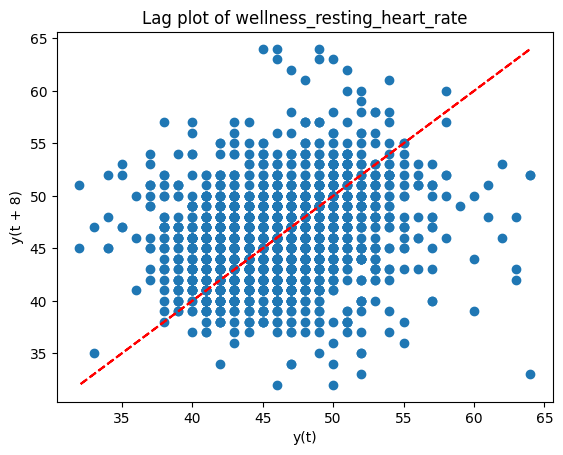

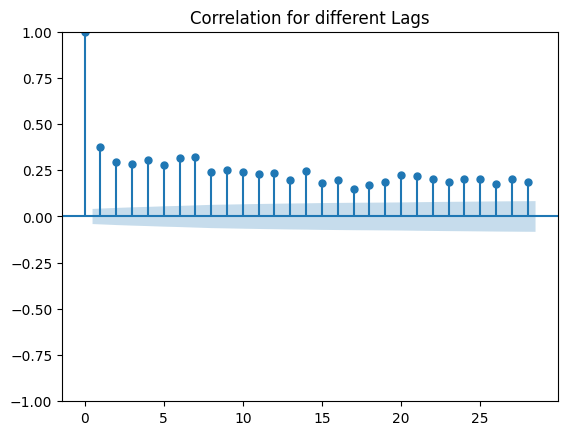

0
[[60.0], [53.0], [49.0], [46.0], [39.0], [49.0], [52.0], [52.0]] - 52.0
1
[[53.0], [49.0], [46.0], [39.0], [49.0], [52.0], [52.0], [52.0]] - 54.0
2
[[49.0], [46.0], [39.0], [49.0], [52.0], [52.0], [52.0], [54.0]] - 48.0
3
[[46.0], [39.0], [49.0], [52.0], [52.0], [52.0], [54.0], [48.0]] - 56.0
4
[[39.0], [49.0], [52.0], [52.0], [52.0], [54.0], [48.0], [56.0]] - 54.0
5
[[49.0], [52.0], [52.0], [52.0], [54.0], [48.0], [56.0], [54.0]] - 49.0
6
[[52.0], [52.0], [52.0], [54.0], [48.0], [56.0], [54.0], [49.0]] - 48.0
7
[[52.0], [52.0], [54.0], [48.0], [56.0], [54.0], [49.0], [48.0]] - 51.0
8
[[52.0], [54.0], [48.0], [56.0], [54.0], [49.0], [48.0], [51.0]] - 54.0
9
[[54.0], [48.0], [56.0], [54.0], [49.0], [48.0], [51.0], [54.0]] - 52.0
10
[[48.0], [56.0], [54.0], [49.0], [48.0], [51.0], [54.0], [52.0]] - 48.0
11
[[56.0], [54.0], [49.0], [48.0], [51.0], [54.0], [52.0], [48.0]] - 52.0
12
[[54.0], [49.0], [48.0], [51.0], [54.0], [52.0], [48.0], [52.0]] - 48.0
13
[[49.0], [48.0], [51.0], [54.0],

In [6]:
import pandas as pd
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
import datetime
import numpy as np
from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt


SEQUENCE_SIZE = 8 # number of values in the sequence to be averaged

data = pd.read_csv("Wellness_Data_All.csv")
#drop all rows that have NaN values wellness_resting_heart_rate column
data = data.dropna(subset=['wellness_resting_heart_rate'])

data = data[['calendar_date','wellness_resting_heart_rate']]

# Exclude outliers
data = data[data['wellness_resting_heart_rate']>30]

# Plot lag plot of wellness_resting_heart_rate to check for autocorrelation. 
# Comparing the values of the current time step with the values of the previous time steps.
lag_plot(data['wellness_resting_heart_rate'],lag=SEQUENCE_SIZE)
#plot line of best fit
z = np.polyfit(data['wellness_resting_heart_rate'], data['wellness_resting_heart_rate'], 1)
p = np.poly1d(z)
plt.plot(data['wellness_resting_heart_rate'],p(data['wellness_resting_heart_rate']),"r--")  
plt.title('Lag plot of wellness_resting_heart_rate')
plt.show()
#Plotting the corelation for various lags
plot_acf(data['wellness_resting_heart_rate'], lags=28) 
plt.title('Correlation for different Lags')
plt.show()

pred_column = 'wellness_resting_heart_rate'

data[pred_column] = data[pred_column].astype(float)

data = data.sort_values('calendar_date', ascending=True)
data = data.reset_index(drop=True)

# calculate the size of the test set as 20% of the data set
days_back = int(len(data)*0.2)

# Benchmark - Persistence model (predict the next value from the perevious value)
lag = 1
values = pd.DataFrame(data['wellness_resting_heart_rate'].values)
dataframe = pd.concat([values.shift(lag), values], axis=1)
dataframe.columns = ['t-lag', 't+lag']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-days_back], X[len(X)-days_back:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
# Evaluate benchmark model
benchmark_corr, _ = pearsonr(test_y, predictions)
benchmark_rmse = np.sqrt(mean_squared_error(test_y, predictions))
benchmark_mape =  mean_absolute_percentage_error(test_y, predictions)*100

# calculate the date 20% of the data back from the last date in the data set and assign to today variable
today = datetime.datetime.today()-datetime.timedelta(days=days_back)
data['calendar_date']= pd.to_datetime(data['calendar_date'])

rmssd_train_df = data[data['calendar_date']<today]
rmssd_test_df = data[data['calendar_date']>=today]

rmssd_train_pred, rmssd_test_pred = [df[pred_column].tolist() for df in (rmssd_train_df, rmssd_test_df)]

def to_sequences(seq_size, obs):
    x, y = [], []
    for i in range(len(obs)-seq_size):
        print(i)
        window = obs[i:(i+seq_size)]
        after_window = obs[i+seq_size]
        window = [[x] for x in window]
        print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
x_train,y_train = to_sequences(SEQUENCE_SIZE,rmssd_train_pred)
x_test,y_test = to_sequences(SEQUENCE_SIZE,rmssd_test_pred)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    num_layers,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    num_layers=6,# PG:Default is 6
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

pred = model.predict(x_test)

Evaluate the Predictions.

In [7]:
model_rmse = np.sqrt(metrics.mean_squared_error(y_test,pred))
model_mape =  mean_absolute_percentage_error(y_test,pred)*100
model_corr, _ = pearsonr(y_test,pred)

# Print the results
print('---------------------------------')
print("Benchmark model RMSE: {}".format(benchmark_rmse))
print("Transformer model RMSE: {}".format(model_rmse))
print('---------------------------------')
print("Benchmark model MAPE: {} %".format(benchmark_mape))
print("Transformer model MAPE: {} %".format(model_mape))
print('---------------------------------')

---------------------------------
Benchmark model RMSE: 2.9978157987639564
Transformer model RMSE: 2.7796770685178407
---------------------------------
Benchmark model MAPE: 5.2652351826472525 %
Transformer model MAPE: 4.918296920152881 %
---------------------------------


Plots.

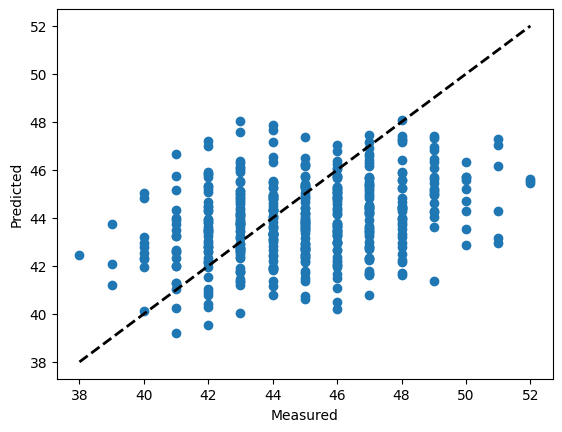

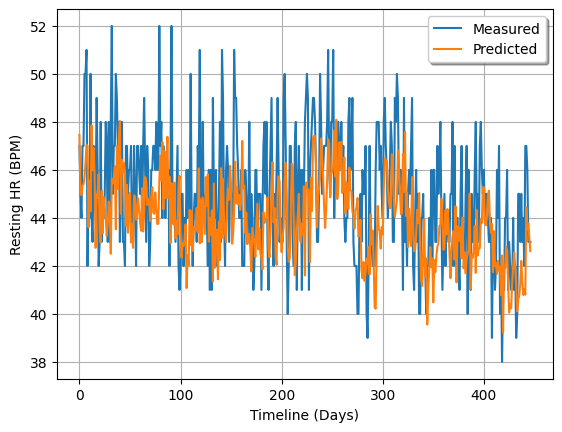

In [8]:
# Plot the predicted vs measured on a scatter plot
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Plot predicted vs Measured on a line plot
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Measured")
plt.plot(x_ax, pred, label="Predicted")
plt.xlabel('Timeline (Days)')
plt.ylabel('Resting HR (BPM)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()